# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

The second notebook created a new language model from the SNLI dataset.
This notebook will adapt that model to predicting the SNLI category for sentence pairs.
The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [1]:
from fastai.text import *
import html

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data

snli_root = './data/snli_1.0/'
token_files = './data/tokens/'

## Create a new dataloader to create sentence pairs

In [2]:
class SiameseDataLoader():
    def __init__(self, sentence_pairs, pad_val, batch_size=32):
        self.sentence_pairs = sentence_pairs
        self.batch_size = batch_size
        self.index = 0
        self.pad_val = pad_val
     
    def shuffle(self):
        def srtfn(x):
            return x[:, -1] + random.randint(-5, 5)
        
        order = np.argsort(srtfn(self.sentence_pairs))
        self.sentence_pairs = self.sentence_pairs[order]
        
    def __iter__(self):
        return self
    
    def fill_tensor(self, sentences, max_len):
        data = np.zeros((max_len, len(sentences)), dtype=np.long)
        data.fill(self.pad_val)
        
        for i, s in enumerate(sentences): 
            start_idx = max_len - len(s)
            for j, p in enumerate(s):
                data[:,i][start_idx+j] = p
            
        return torch.LongTensor([data.tolist()]).cuda()
     
    def batch(self):
        return self.index//self.batch_size
    
    def __len__(self):
        return len(self.sentence_pairs)//self.batch_size
    
    def __next__(self):
        #how many examples to ananlyise for this round
        num = min(self.batch_size, len(self.sentence_pairs) - self.index)
        
        if num < 1:
            raise StopIteration  # signals "the end"
            
        #collect the sentences
        max_len = 0
        first = []
        second = []
        labels = torch.LongTensor(num)
        
        for i in range(num):
            a, b, l, _ = self.sentence_pairs[self.index + i]
            
            if len(a) > max_len:
                max_len = len(a)
            
            if len(b) > max_len:
                max_len = len(b)
            
            first.append(a)
            second.append(b)
            labels[i] = l
            
        self.index += num
             
        return (self.fill_tensor(first, max_len).cuda(),
                self.fill_tensor(second, max_len).cuda(),
                labels.cuda()
               )

In [3]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
pad_tok = stoi['_pad_']

sentence_pairs_train = np.load(f'{token_files}snli_tok_train.npy')
sentence_pairs_dev = np.load(f'{token_files}snli_tok_dev.npy')
sentence_pairs_test = np.load(f'{token_files}snli_tok_test.npy')

def print_sentence(s):
    sentence = ""
    for tok in s:
        sentence += " "+itos[tok]
    print(sentence)

print_sentence(sentence_pairs_train[0][0])
print_sentence(sentence_pairs_train[0][1])

print_sentence(sentence_pairs_dev[0][0])
print_sentence(sentence_pairs_dev[0][1])

print_sentence(sentence_pairs_test[0][0])
print_sentence(sentence_pairs_test[0][1])

 x_bos a person on a horse jumps over a broken down airplane .
 x_bos a person is training his horse for a competition .
 x_bos two women are embracing while holding to go packages .
 x_bos the sisters are hugging goodbye while holding to go packages after just eating lunch .
 x_bos this church choir sings to the masses as they sing joyous songs from the book at a church .
 x_bos the church has cracks in the ceiling .


# Check the dataloader

In [4]:
training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
s = training_data.sentence_pairs[0][0]
t = training_data.fill_tensor([s], len(s))
for s in t[0]:
    print(itos[int(s[0])], end=' ')

x_bos a person on a horse jumps over a broken down airplane . 

## Siamese network

In [5]:
class SiameseClassifier(nn.Module):
    
    def __init__(self, encoder, linear):
        super().__init__()
        self.encoder = encoder
        self.linear = linear
    
    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)

    def pool_outputs(self, output):
        sl, bs,_ = output.size()
        avgpool = self.pool(output, bs, False)
        maxpool = self.pool(output, bs, True)
        return torch.cat([output[-1], maxpool, avgpool], 1)
        
    def forward_once(self, input):
        raw_outputs, outputs = self.encoder(input)
        out = self.pool_outputs(outputs[-1])
        return out
    
    def forward(self, in1, in2):
        u = self.forward_once(in1)
        v = self.forward_once(in2)
        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        out = self.linear(features)
        return out 
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

class LinearClassifier(nn.Module):
    def __init__(self, layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList([LinearBlock(layers[i], layers[i + 1], dropout) for i in range(len(layers) - 1)])
        
    def forward(self, input):
        x = input
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x


In [6]:
#these are the values used for the original LM
em_sz, nh, nl = 400, 1150, 3
bptt = 70
max_seq = bptt * 20
cats = 3

## Load our pretrained model then build the Siamese network from it

## Training loop
This should be converted over to the fast.ai learner but I'm not sure how to do that yet.

In [7]:
log_interval = 1000
criterion = nn.CrossEntropyLoss()
#criterion = nn.CosineEmbeddingLoss()

def evaluate(model, data_loader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    total_loss = 0.
    num_correct = 0
    total = 0 
    
    for a, b, l in data_loader:
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
    return (total_loss / total, num_correct / total)

def train(model, data_loader, optimizer):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    model.train() 
    
    total_loss = 0.
    num_correct = 0
    total = 0 
        
    for a, b, l in data_loader:
        optimizer.zero_grad()
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
        loss.backward()
        optimizer.step()

        batch = data_loader.batch()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / total
            elapsed = time.time() - start_time
            batches = len(data_loader)
            ms = elapsed * 1000 / log_interval
            print(f'| {batch:5d}/{batches:5d} batches', end=" ")
            print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f} acc {num_correct / total}')
            #print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f}')
            total_loss = 0
            total = 0
            num_correct = 0
            start_time = time.time()

In [8]:
best_loss = 100
def training_loop(model, epochs, optimizer, scheduler = None):
    
    global best_loss
    for epoch in range(epochs):

        print(f'Start epoch {epoch:3d} training with lr ', end="")
        for g in optimizer.param_groups:
            print(g['lr'], end=" ")
        print("")
        
        training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
        training_data.shuffle()

        epoch_start_time = time.time()
        
        train(siamese_model, training_data, optimizer)
        if scheduler != None:
            scheduler.step()

        dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
        val_loss, accuracy = evaluate(siamese_model, dev_data)

        delta_t = (time.time() - epoch_start_time)
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {delta_t:5.2f}s | valid loss {val_loss:5.2f} accuracy {accuracy} learning rates')
        for g in optimizer.param_groups:
            print(g['lr'])
        print('-' * 89)

        if val_loss < best_loss:
            best_loss = val_loss
            with open(f'./siamese_model{val_loss:0.2f}{accuracy:0.2f}.pt', 'wb') as f:
                torch.save(siamese_model, f)

In [9]:
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_loss(losses):
    plt.semilogx(losses[:,0], losses[:,1])
    plt.semilogx(losses[:,0], butter_lowpass_filtfilt(losses[:,1], 300, 5000))
    plt.show()

def find_lr(model, model_to_optim, data_loader):
    losses = []
    model.train() 
    criterion = nn.CrossEntropyLoss()
    lr = 0.00001
    for a, b, l in data_loader:
        optimizer = optim.SGD(model_to_optim.parameters(), lr=lr)
        #optimizer = optim.Adam(model_to_optim.parameters(), lr=lr)
        optimizer.zero_grad()
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        
        los_val = loss.item()
        losses.append((lr, los_val))
        if los_val > 5:
            break
        
        loss.backward()
        optimizer.step()
        
        lr *= 1.05
    losses = np.array(losses)
    #plot_loss(losses)
    return losses

In [18]:
SNLI_LM = torch.load("snli_language_model.pt")

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.4
SNLI_encoder = MultiBatchRNN(bptt, max_seq, vocab_size, em_sz, nh, nl, pad_tok, dropouti=dps[0], wdrop=dps[2], dropoute=dps[3], dropouth=dps[4])

SNLI_encoder.load_state_dict(SNLI_LM[0].state_dict())

#2 pooled vectors, of 3 times the embedding size
siamese_model = SiameseClassifier(SNLI_encoder, LinearClassifier(layers=[em_sz*3*4, nh, 3], dropout=0.4)).cuda()

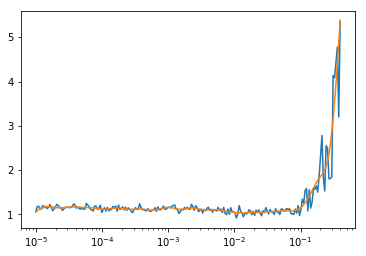

In [12]:
dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
losses = find_lr(siamese_model, siamese_model, dev_data)
plot_loss(np.array(losses))

In [23]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = False

optimizer = optim.SGD(siamese_model.parameters(), lr=0.001)
training_loop(siamese_model.linear, 1, optimizer)

Start epoch   0 training with lr 0.001 
|  1000/17167 batches | ms/batch 14.81 | loss 0.9315 acc 0.57040625
|  2000/17167 batches | ms/batch 15.86 | loss 0.9426 acc 0.5574375
|  3000/17167 batches | ms/batch 16.50 | loss 0.9429 acc 0.5551875
|  4000/17167 batches | ms/batch 17.09 | loss 0.9569 acc 0.54521875
|  5000/17167 batches | ms/batch 17.51 | loss 0.9535 acc 0.54403125
|  6000/17167 batches | ms/batch 17.96 | loss 0.9579 acc 0.54275
|  7000/17167 batches | ms/batch 18.41 | loss 0.9613 acc 0.5358125
|  8000/17167 batches | ms/batch 18.98 | loss 0.9587 acc 0.53903125
|  9000/17167 batches | ms/batch 19.42 | loss 0.9612 acc 0.53721875
| 10000/17167 batches | ms/batch 19.99 | loss 0.9547 acc 0.54028125
| 11000/17167 batches | ms/batch 20.63 | loss 0.9585 acc 0.53871875
| 12000/17167 batches | ms/batch 21.44 | loss 0.9607 acc 0.53503125
| 13000/17167 batches | ms/batch 22.21 | loss 0.9616 acc 0.53978125
| 14000/17167 batches | ms/batch 23.14 | loss 0.9601 acc 0.53853125
| 15000/17167 

In [24]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = True

for lr in [x/200+0.005 for x in range(20)]:
    optimizer = optim.SGD(siamese_model.parameters(), lr=lr)
    training_loop(siamese_model, 1, optimizer)

Start epoch   0 training with lr 0.005 
|  1000/17167 batches | ms/batch 31.86 | loss 0.9271 acc 0.574125
|  2000/17167 batches | ms/batch 34.50 | loss 0.9278 acc 0.56896875
|  3000/17167 batches | ms/batch 36.01 | loss 0.9226 acc 0.5688125
|  4000/17167 batches | ms/batch 37.56 | loss 0.9332 acc 0.56015625
|  5000/17167 batches | ms/batch 38.61 | loss 0.9257 acc 0.5644375
|  6000/17167 batches | ms/batch 39.72 | loss 0.9317 acc 0.55896875
|  7000/17167 batches | ms/batch 40.74 | loss 0.9342 acc 0.5561875
|  8000/17167 batches | ms/batch 42.09 | loss 0.9351 acc 0.558875
|  9000/17167 batches | ms/batch 43.18 | loss 0.9357 acc 0.5564375
| 10000/17167 batches | ms/batch 44.56 | loss 0.9309 acc 0.55953125
| 11000/17167 batches | ms/batch 46.15 | loss 0.9315 acc 0.5585
| 12000/17167 batches | ms/batch 48.03 | loss 0.9303 acc 0.55859375
| 13000/17167 batches | ms/batch 49.87 | loss 0.9339 acc 0.55453125
| 14000/17167 batches | ms/batch 52.01 | loss 0.9315 acc 0.55578125
| 15000/17167 batche

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.78 | loss 0.6576 acc 0.7301875
|  2000/17167 batches | ms/batch 34.42 | loss 0.6743 acc 0.7169375
|  3000/17167 batches | ms/batch 35.94 | loss 0.6866 acc 0.70765625
|  4000/17167 batches | ms/batch 37.44 | loss 0.6910 acc 0.706125
|  5000/17167 batches | ms/batch 38.56 | loss 0.6902 acc 0.7039375
|  6000/17167 batches | ms/batch 39.67 | loss 0.6962 acc 0.70353125
|  7000/17167 batches | ms/batch 40.70 | loss 0.7029 acc 0.6985625
|  8000/17167 batches | ms/batch 42.04 | loss 0.7046 acc 0.69346875
|  9000/17167 batches | ms/batch 43.08 | loss 0.7168 acc 0.68959375
| 10000/17167 batches | ms/batch 44.51 | loss 0.7083 acc 0.6946875
| 11000/17167 batches | ms/batch 46.05 | loss 0.7096 acc 0.69225
| 12000/17167 batches | ms/batch 47.94 | loss 0.7130 acc 0.6936875
| 13000/17167 batches | ms/batch 49.74 | loss 0.7231 acc 0.68546875
| 14000/17167 batches | ms/batch 51.86 | loss 0.7250 acc 0.68784375
| 15000/17167 batches | ms/batch 54.55 | loss 0.7252 acc 0.

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Start epoch   0 training with lr 0.065 
|  1000/17167 batches | ms/batch 31.82 | loss 0.6457 acc 0.7345625
|  2000/17167 batches | ms/batch 34.41 | loss 0.6629 acc 0.72140625
|  3000/17167 batches | ms/batch 35.88 | loss 0.6707 acc 0.71659375
|  4000/17167 batches | ms/batch 37.41 | loss 0.6787 acc 0.7128125
|  5000/17167 batches | ms/batch 38.56 | loss 0.6826 acc 0.7079375
|  6000/17167 batches | ms/batch 39.70 | loss 0.6815 acc 0.71325
|  7000/17167 batches | ms/batch 40.67 | loss 0.6960 acc 0.69884375
|  8000/17167 batches | ms/batch 42.00 | loss 0.6944 acc 0.700375
|  9000/17167 batches | ms/batch 43.08 | loss 0.7055 acc 0.69815625
| 10000/17167 batches | ms/batch 44.46 | loss 0.6943 acc 0.70165625
| 11000/17167 batches | ms/batch 46.05 | loss 0.7027 acc 0.6974375
| 12000/17167 batches | ms/batch 47.94 | loss 0.7037 acc 0.69446875
| 13000/17167 batches | ms/batch 49.74 | loss 0.7114 acc 0.69228125
| 14000/17167 batches | ms/batch 51.85 | loss 0.7164 acc 0.6899375
| 15000/17167 batc

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.80 | loss 0.6433 acc 0.734125
|  2000/17167 batches | ms/batch 34.43 | loss 0.6571 acc 0.7263125
|  3000/17167 batches | ms/batch 35.93 | loss 0.6639 acc 0.7214375
|  4000/17167 batches | ms/batch 37.48 | loss 0.6701 acc 0.7153125
|  5000/17167 batches | ms/batch 38.58 | loss 0.6756 acc 0.71190625
|  6000/17167 batches | ms/batch 39.67 | loss 0.6731 acc 0.71428125
|  7000/17167 batches | ms/batch 40.76 | loss 0.6840 acc 0.7065625
|  8000/17167 batches | ms/batch 42.11 | loss 0.6906 acc 0.70228125
|  9000/17167 batches | ms/batch 43.17 | loss 0.7019 acc 0.698125
| 10000/17167 batches | ms/batch 44.54 | loss 0.6953 acc 0.70228125
| 11000/17167 batches | ms/batch 46.15 | loss 0.6930 acc 0.70128125
| 12000/17167 batches | ms/batch 48.06 | loss 0.6954 acc 0.70153125
| 13000/17167 batches | ms/batch 49.90 | loss 0.7024 acc 0.69659375
| 14000/17167 batches | ms/batch 52.01 | loss 0.7072 acc 0.69478125
| 15000/17167 batches | ms/batch 54.64 | loss 0.7147 acc

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.88 | loss 0.6316 acc 0.74125
|  2000/17167 batches | ms/batch 34.50 | loss 0.6469 acc 0.72909375
|  3000/17167 batches | ms/batch 36.04 | loss 0.6581 acc 0.72325
|  4000/17167 batches | ms/batch 37.50 | loss 0.6633 acc 0.71803125
|  5000/17167 batches | ms/batch 38.59 | loss 0.6666 acc 0.71690625
|  6000/17167 batches | ms/batch 39.66 | loss 0.6653 acc 0.71853125
|  7000/17167 batches | ms/batch 40.73 | loss 0.6753 acc 0.7138125
|  8000/17167 batches | ms/batch 42.08 | loss 0.6800 acc 0.70803125
|  9000/17167 batches | ms/batch 43.17 | loss 0.6906 acc 0.70459375
| 10000/17167 batches | ms/batch 44.55 | loss 0.6820 acc 0.70953125
| 11000/17167 batches | ms/batch 46.17 | loss 0.6868 acc 0.70571875
| 12000/17167 batches | ms/batch 48.08 | loss 0.6880 acc 0.70290625
| 13000/17167 batches | ms/batch 49.82 | loss 0.6910 acc 0.700625
| 14000/17167 batches | ms/batch 51.93 | loss 0.7071 acc 0.69203125
| 15000/17167 batches | ms/batch 54.62 | loss 0.7034 acc 

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.78 | loss 0.6249 acc 0.7436875
|  2000/17167 batches | ms/batch 34.40 | loss 0.6366 acc 0.73615625
|  3000/17167 batches | ms/batch 35.90 | loss 0.6475 acc 0.72853125
|  4000/17167 batches | ms/batch 37.42 | loss 0.6575 acc 0.72421875
|  5000/17167 batches | ms/batch 38.58 | loss 0.6573 acc 0.723875
|  6000/17167 batches | ms/batch 39.71 | loss 0.6624 acc 0.7208125
|  7000/17167 batches | ms/batch 40.74 | loss 0.6696 acc 0.7155
|  8000/17167 batches | ms/batch 42.08 | loss 0.6777 acc 0.71203125
|  9000/17167 batches | ms/batch 43.16 | loss 0.6805 acc 0.70803125
| 10000/17167 batches | ms/batch 44.53 | loss 0.6761 acc 0.71084375
| 11000/17167 batches | ms/batch 46.15 | loss 0.6816 acc 0.70621875
| 12000/17167 batches | ms/batch 48.02 | loss 0.6791 acc 0.70628125
| 13000/17167 batches | ms/batch 49.86 | loss 0.6898 acc 0.70384375
| 14000/17167 batches | ms/batch 51.96 | loss 0.6902 acc 0.70471875
| 15000/17167 batches | ms/batch 54.63 | loss 0.6989 acc

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.84 | loss 0.6176 acc 0.75025
|  2000/17167 batches | ms/batch 34.43 | loss 0.6326 acc 0.73675
|  3000/17167 batches | ms/batch 35.96 | loss 0.6454 acc 0.72890625
|  4000/17167 batches | ms/batch 37.53 | loss 0.6525 acc 0.72409375
|  5000/17167 batches | ms/batch 38.63 | loss 0.6476 acc 0.72646875
|  6000/17167 batches | ms/batch 39.68 | loss 0.6534 acc 0.72621875
|  7000/17167 batches | ms/batch 40.71 | loss 0.6629 acc 0.718125
|  8000/17167 batches | ms/batch 42.04 | loss 0.6608 acc 0.7195625
|  9000/17167 batches | ms/batch 43.09 | loss 0.6790 acc 0.70990625
| 10000/17167 batches | ms/batch 44.48 | loss 0.6713 acc 0.7156875
| 11000/17167 batches | ms/batch 46.04 | loss 0.6711 acc 0.7154375
| 12000/17167 batches | ms/batch 47.95 | loss 0.6802 acc 0.7075625
| 13000/17167 batches | ms/batch 49.76 | loss 0.6846 acc 0.7038125
| 14000/17167 batches | ms/batch 51.86 | loss 0.6894 acc 0.70615625
| 15000/17167 batches | ms/batch 54.56 | loss 0.6898 acc 0.70

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.84 | loss 0.6093 acc 0.751625
|  2000/17167 batches | ms/batch 34.45 | loss 0.6250 acc 0.7429375
|  3000/17167 batches | ms/batch 35.92 | loss 0.6318 acc 0.7381875
|  4000/17167 batches | ms/batch 37.40 | loss 0.6436 acc 0.72890625
|  5000/17167 batches | ms/batch 38.61 | loss 0.6439 acc 0.72984375
|  6000/17167 batches | ms/batch 39.67 | loss 0.6505 acc 0.725375
|  7000/17167 batches | ms/batch 40.68 | loss 0.6518 acc 0.7213125
|  8000/17167 batches | ms/batch 42.03 | loss 0.6568 acc 0.722
|  9000/17167 batches | ms/batch 43.06 | loss 0.6683 acc 0.71659375
| 10000/17167 batches | ms/batch 44.49 | loss 0.6661 acc 0.71665625
| 11000/17167 batches | ms/batch 46.10 | loss 0.6668 acc 0.7134375
| 12000/17167 batches | ms/batch 47.99 | loss 0.6685 acc 0.71315625
| 13000/17167 batches | ms/batch 49.79 | loss 0.6764 acc 0.7089375
| 14000/17167 batches | ms/batch 51.87 | loss 0.6822 acc 0.71028125
| 15000/17167 batches | ms/batch 54.54 | loss 0.6800 acc 0.711

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Start epoch   0 training with lr 0.095 
|  1000/17167 batches | ms/batch 31.84 | loss 0.6019 acc 0.7564375
|  2000/17167 batches | ms/batch 34.48 | loss 0.6176 acc 0.74528125
|  3000/17167 batches | ms/batch 35.99 | loss 0.6280 acc 0.73975
|  4000/17167 batches | ms/batch 37.50 | loss 0.6356 acc 0.73359375
|  5000/17167 batches | ms/batch 38.64 | loss 0.6400 acc 0.7308125
|  6000/17167 batches | ms/batch 39.74 | loss 0.6421 acc 0.72890625
|  7000/17167 batches | ms/batch 40.78 | loss 0.6529 acc 0.72290625
|  8000/17167 batches | ms/batch 42.06 | loss 0.6518 acc 0.723875
|  9000/17167 batches | ms/batch 43.15 | loss 0.6606 acc 0.7213125
| 10000/17167 batches | ms/batch 44.51 | loss 0.6594 acc 0.720375
| 11000/17167 batches | ms/batch 46.12 | loss 0.6646 acc 0.71621875
| 12000/17167 batches | ms/batch 48.06 | loss 0.6632 acc 0.71684375
| 13000/17167 batches | ms/batch 49.90 | loss 0.6731 acc 0.7095
| 14000/17167 batches | ms/batch 51.97 | loss 0.6766 acc 0.7086875
| 15000/17167 batches |

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.80 | loss 0.5994 acc 0.7574375
|  2000/17167 batches | ms/batch 34.46 | loss 0.6143 acc 0.746875
|  3000/17167 batches | ms/batch 35.99 | loss 0.6263 acc 0.736875
|  4000/17167 batches | ms/batch 37.49 | loss 0.6307 acc 0.734625
|  5000/17167 batches | ms/batch 38.63 | loss 0.6293 acc 0.73475
|  6000/17167 batches | ms/batch 39.75 | loss 0.6369 acc 0.73346875
|  7000/17167 batches | ms/batch 40.78 | loss 0.6405 acc 0.73003125
|  8000/17167 batches | ms/batch 42.11 | loss 0.6458 acc 0.728
|  9000/17167 batches | ms/batch 43.19 | loss 0.6592 acc 0.71953125
| 10000/17167 batches | ms/batch 44.57 | loss 0.6534 acc 0.72303125
| 11000/17167 batches | ms/batch 46.10 | loss 0.6585 acc 0.7195
| 12000/17167 batches | ms/batch 48.06 | loss 0.6584 acc 0.72015625
| 13000/17167 batches | ms/batch 49.90 | loss 0.6634 acc 0.7163125
| 14000/17167 batches | ms/batch 52.01 | loss 0.6740 acc 0.71321875
| 15000/17167 batches | ms/batch 54.68 | loss 0.6721 acc 0.71421875


/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
epochs = 10
optimizer = optim.SGD(siamese_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.001)
training_loop(siamese_model, epochs, optimizer, scheduler)

Start epoch   0 training with lr 0.1 
|  1000/17167 batches | ms/batch 31.62 | loss 0.5024 acc 0.80209375
|  2000/17167 batches | ms/batch 34.31 | loss 0.5148 acc 0.79321875
|  3000/17167 batches | ms/batch 35.82 | loss 0.5347 acc 0.78534375
|  4000/17167 batches | ms/batch 37.30 | loss 0.5352 acc 0.78334375
|  5000/17167 batches | ms/batch 38.46 | loss 0.5359 acc 0.78396875
|  6000/17167 batches | ms/batch 39.57 | loss 0.5396 acc 0.78053125
|  7000/17167 batches | ms/batch 40.60 | loss 0.5543 acc 0.7726875
|  8000/17167 batches | ms/batch 41.96 | loss 0.5542 acc 0.77225
|  9000/17167 batches | ms/batch 43.04 | loss 0.5666 acc 0.767
| 10000/17167 batches | ms/batch 44.45 | loss 0.5545 acc 0.77190625
| 11000/17167 batches | ms/batch 46.04 | loss 0.5641 acc 0.7680625
| 12000/17167 batches | ms/batch 47.98 | loss 0.5672 acc 0.7654375
| 13000/17167 batches | ms/batch 49.82 | loss 0.5715 acc 0.764375
| 14000/17167 batches | ms/batch 51.94 | loss 0.5792 acc 0.76028125
| 15000/17167 batches |

In [62]:
entailed_a = []
entailed_b = []
contra_a = []
contra_b = []
netural_a = []
netural_b = []

In [ ]:

def list2arr(l):
    "Convert list into pytorch Variable."
    return V(np.expand_dims(np.array(l), -1))

def make_prediction_from_list(model, l):
    """
    Encode a list of integers that represent a sequence of tokens.  The
    purpose is to encode a sentence or phrase.

    Parameters
    -----------
    model : fastai language model
    l : list
        list of integers, representing a sequence of tokens that you want to encode`

    """
    arr = list2arr(l)# turn list into pytorch Variable with bs=1
    model.reset()  # language model is stateful, so you must reset upon each prediction
    hidden_states = model(arr)[-1][-1] # RNN Hidden Layer output is last output, and only need the last layer

    #return avg-pooling, max-pooling, and last hidden state
    return hidden_states.mean(0), hidden_states.max(0)[0], hidden_states[-1]


def get_embeddings(encoder, list_list_int):
    """
    Vectorize a list of sequences List[List[int]] using a fast.ai language model.

    Paramters
    ---------
    encoder : sentence_encoder
    list_list_int : List[List[int]]
        A list of sequences to encode

    Returns
    -------
    tuple: (avg, mean, last)
        A tuple that returns the average-pooling, max-pooling over time steps as well as the last time step.
    """
    n_rows = len(list_list_int)
    n_dim = encoder.nhid
    avgarr = np.empty((n_rows, n_dim))
    maxarr = np.empty((n_rows, n_dim))
    lastarr = np.empty((n_rows, n_dim))

    for i in tqdm_notebook(range(len(list_list_int))):
        avg_, max_, last_ = make_prediction_from_list(encoder, list_list_int[i])
        avgarr[i,:] = avg_.data.cpu().numpy()
        maxarr[i,:] = max_.data.cpu().numpy()
        lastarr[i,:] = last_.data.cpu().numpy()

    return avgarr, maxarr, lastarr

def encode_sentences(sentences, encoding_dict):
    sentences_enc = []
    for sent in sentences:
        sent_enc = []
        for word in f'{BOS} ' +fixup(sent):
            sent_enc.append(encoding_dict[word])
        sentences_enc.append(sent_enc)
        
    return sentences_enc

In [ ]:
siamese_model = torch.load('siamese_model0.73.pt')
siamese_model.encoder.nhid = 400

In [ ]:
entailed_a_vec = get_embeddings(siamese_model.encoder, encode_sentences(entailed_a, stoi))
entailed_b_vec = get_embeddings(siamese_model.encoder, encode_sentences(entailed_b, stoi))

In [ ]:
import nmslib

def create_nmslib_search_index(numpy_vectors):
    """Create search index using nmslib.
    Parameters
    ==========
    numpy_vectors : numpy.array
        The matrix of vectors
    Returns
    =======
    nmslib object that has index of numpy_vectors
    """

    search_index = nmslib.init(method='hnsw', space='cosinesimil')
    search_index.addDataPointBatch(numpy_vectors)
    search_index.createIndex({'post': 2}, print_progress=True)
    return search_index

def percent_matching(query_vec, searchindex, k=10):
    num_found = 0
    num_total = len(query_vec)
    for i in range(num_total):
        query = query_vec[i]
        idxs, dists = searchindex.knnQuery(query, k=k)
        if i in idxs:
            num_found += 1

    return 100 * num_found/num_total


In [ ]:
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[0])
percent_matching(entailed_a_vec[0], entailed_b_max_searchindex, 10)

In [ ]:
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[1])
percent_matching(entailed_a_vec[1], entailed_b_max_searchindex, 20)

In [ ]:
entailed_b_last_searchindex = create_nmslib_search_index(entailed_b_vec[2])
percent_matching(entailed_a_vec[2], entailed_b_last_searchindex, 10)

In [ ]:
entailed_a_concat = np.concatenate((entailed_a_vec[0], entailed_a_vec[1], entailed_a_vec[2]), axis=1)
entailed_b_concat = np.concatenate((entailed_b_vec[0], entailed_b_vec[1], entailed_b_vec[2]), axis=1)
entailed_b_concat_searchindex = create_nmslib_search_index(entailed_b_concat)

In [ ]:
percent_matching(entailed_a_concat, entailed_b_concat_searchindex, 5)

In [ ]:
def show_similar(query, query_idx, searchindex):
    idx, _ = searchindex.knnQuery(query[query_idx], k=10)
    matched = []
    for i in idx:
        matched.append(entailed_b[i])
    
    match = query_idx in idx
    
    return match, entailed_a[query_idx], entailed_b[query_idx], matched

In [ ]:
for i in range(10):
    results = show_similar(entailed_a_vec[1], i, entailed_b_max_searchindex)
    if results[0]:
        print(results[1])
        print(results[2])
        for result in results[3]:
            print("\t"+result)
        print("")